# Population split

Divergence models describe populations diverging from common ancestral populations without subsequent gene flow.<br>
For the sake of simplicity, we will here assume that there is no change in population size, and that the size of the ancestral population equals that of both diverging populations. 

In [1]:
import msprime
import allel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import SVG

Population splits occur when some fraction of the lineages fro a population migrate to another population.

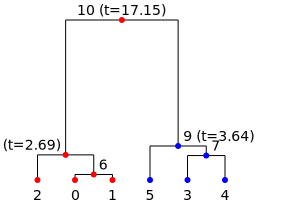

In [2]:
ts  = msprime.simulate(
    population_configurations=[
        msprime.PopulationConfiguration(sample_size=3),
        msprime.PopulationConfiguration(sample_size=3)],
    demographic_events=[
        msprime.MassMigration(15, source=1, dest=0)],
    random_seed=20)
tree = ts.first()
colour_map = {0:"red", 1:"blue"}
node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
node_labels = {
    u: (str(u) if u < 8 else "{} (t={:.2f})".format(u, tree.time(u))) 
    for u in tree.nodes()}
SVG(tree.draw(node_colours=node_colours, node_labels=node_labels, width=300))

This tree represents 2 isolated populations which coalesce down to a single lineage. The population split at time 15 (which produced all individuals in population 1), then results in this lineage migrating back to population 0, where it coalesces with the ancestor of samples 0, 1 and 2.<br>
It means that at time 15, a fraction of population 0 (in red) migrated to population 1, resulting in the blue leaves.

## Population split 150 generations ago

### Only modern samples

In [3]:
Ne = 15000
nbPops = 2
nbSamples = 20

population_configurations=[
        msprime.PopulationConfiguration(sample_size=2*nbSamples, initial_size=Ne),
        msprime.PopulationConfiguration(sample_size=2*nbSamples, initial_size=Ne)]
demographic_events=[
        msprime.MassMigration(150, source=1, dest=0)]

In [4]:
def run_sim(num_replicates, nbSamples, nbDemes, population_configurations, demographic_events):
    """
    Runs num_replicates simulations, each one generating a very small number of SNPs. All these mutations are
    pooled in order get thousands of independent SNPs.
    """
    s = 0
    replicates = msprime.simulate(length= 300,
                                  mutation_rate=1e-8, recombination_rate=1e-8,
                                  num_replicates=num_replicates,
                                  population_configurations = population_configurations,
                                  demographic_events=demographic_events)
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (nbDemes*nbSamples,2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    return(haplotypes)

In [5]:
g = allel.model.GenotypeArray(run_sim(5000, nbSamples, nbPops, population_configurations,
                                                         demographic_events))
g

<GenotypeArray shape=(4543, 40, 2) dtype=int8>
0/0 0/0 1/0 0/0 0/0 ... 1/0 0/0 0/1 0/0 0/0
1/1 0/1 0/1 1/0 0/1 ... 1/1 1/1 1/1 1/1 1/0
0/0 0/0 0/0 0/0 1/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/1 0/0 0/0 0/0 0/0
0/1 0/0 0/1 0/1 0/0 ... 0/0 0/0 1/0 1/0 1/0
0/0 0/0 1/1 1/1 0/1 ... 1/0 1/0 0/0 0/0 1/0

In [6]:
gn = g.to_n_alt()[:]

# PCA
coords, model = allel.stats.pca(gn)
coords.shape

pops_colors = {
    'pop1': '#cc0000',
    'pop2': '#336699'
}

pops = []
for d in np.arange(nbPops):
    pops.append("pop" + str(d+1))

In [7]:
p = ['1' for i in np.arange(nbSamples)] + ['2' for i in np.arange(nbSamples)]
# with open("genotype_modern_split.txt", "w") as f:
#     i = 0
#     for ind in np.arange(gn.shape[1]):
#         f.write("%s\t" % p[i])
#         for var in np.arange(gn.shape[0]):
#             if var != gn.shape[0]-1:
#                 f.write("%s\t" % gn[var, ind])
#             else:
#                 f.write("%s\n" % gn[var, ind])
        i += 1

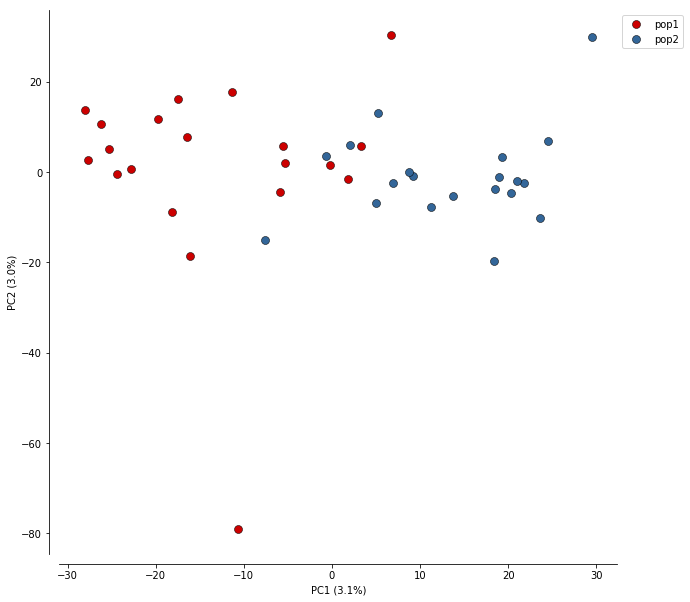

In [8]:
def plot_pca_coords(coords, model, pc1, pc2, ax):
    i = 0
    for pop in pops:
        x = coords[i:i+nbSamples, pc1]
        y = coords[i:i+nbSamples, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=pop, color=pops_colors[pop], markersize=8, mec='k', mew=.5)
        i += nbSamples
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    
fig, ax = plt.subplots(figsize=(10, 10))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

Text(0.5,1.02,'PC maps')

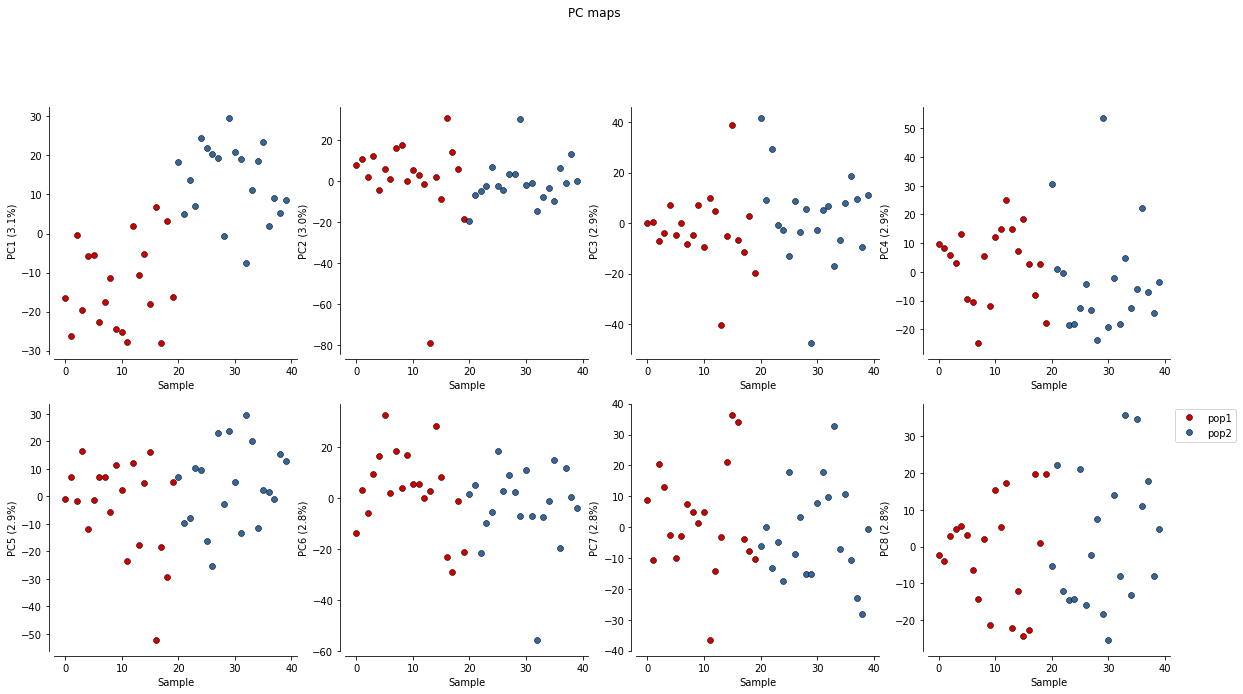

In [9]:
def plot_PC_maps(coords, model, pc, ax):
    """
    Plots each PC element against the sample number.
    """
    sns.despine(ax=ax, offset=5)
    i = 0
    for pop in pops:
        y = coords[i:i+nbSamples, pc]
        x = np.arange(i, i+nbSamples)
        ax.plot(x, y, marker='o', linestyle=' ', label=pop, color=pops_colors[pop], markersize=6, mec='k', mew=.5)
        i += nbSamples
    ax.set_ylabel('PC%s (%.1f%%)' % (pc+1, model.explained_variance_ratio_[pc]*100))
    ax.set_xlabel('Sample')

    
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,4,1)
plot_PC_maps(coords, model, 0, ax)
ax = fig.add_subplot(2,4,2)
plot_PC_maps(coords, model, 1, ax)
ax = fig.add_subplot(2,4,3)
plot_PC_maps(coords, model, 2, ax)
ax = fig.add_subplot(2,4,4)
plot_PC_maps(coords, model, 3, ax)
ax = fig.add_subplot(2,4,5)
plot_PC_maps(coords, model, 4, ax)
ax = fig.add_subplot(2,4,6)
plot_PC_maps(coords, model, 5, ax)
ax = fig.add_subplot(2,4,7)
plot_PC_maps(coords, model, 6, ax)
ax = fig.add_subplot(2,4,8)
plot_PC_maps(coords, model, 7, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
fig.suptitle('PC maps', y=1.02)

### Modern samples + ancient samples taken before split in source population

150 generations ago, a population split into 2 populations.<br>
Modern samples are taken from these 2 populations. <br>
Ancient samples are taken 500 generations ago, i.e. 350 generations before the population split.

In [10]:
Ne = 15000
nbPops = 2
nbM = 20
nbA = 20

population_configurations=[
    msprime.PopulationConfiguration(initial_size=Ne),
    msprime.PopulationConfiguration(initial_size=Ne)]
demographic_events=[
    msprime.MassMigration(150, source=1, dest=0)] # pop0 migrated to pop1
samples = [msprime.Sample(0,0) for i in np.arange(2*nbM)] + [msprime.Sample(1,0) for i in np.arange(2*nbM)] + [msprime.Sample(0,500) for i in np.arange(2*nbA)]

In [11]:
def run_sim2(num_replicates, nbM, nbA, nbDemes, population_configurations, demographic_events):
    """
    Runs num_replicates simulations, each one generating a very small number of SNPs. All these mutations are
    pooled in order get thousands of independent SNPs.
    """
    s = 0
    replicates = msprime.simulate(length= 400,
                                  samples = samples,
                                  mutation_rate=1e-8, recombination_rate=1e-8,
                                  num_replicates=num_replicates,
                                  population_configurations = population_configurations,
                                  demographic_events=demographic_events,
                                 random_seed = 10)
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (nbDemes*nbM + nbA,2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    return(haplotypes)

In [12]:
g = allel.model.GenotypeArray(run_sim2(30000, nbM, nbA, nbPops, population_configurations,
                                                         demographic_events))
g

<GenotypeArray shape=(40554, 60, 2) dtype=int8>
0/0 1/0 1/0 0/0 0/0 ... 0/1 0/0 0/0 1/0 0/1
0/0 1/0 1/0 0/0 0/0 ... 0/1 0/0 0/0 1/0 0/1
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/1 0/0 0/0
...
0/0 0/1 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 1/1 0/1 0/0 1/0 ... 1/1 0/0 1/1 1/1 1/1

In [13]:
gn = g.to_n_alt()[:]

# PCA
coords, model = allel.stats.pca(gn)
coords.shape

pops_colors = {
    'pop0': '#cc0000',
    'pop1': '#336699',
    'before split': '#009933'
}

pops = []
for d in np.arange(nbPops):
    pops.append("pop" + str(d))
pops.append('before split')

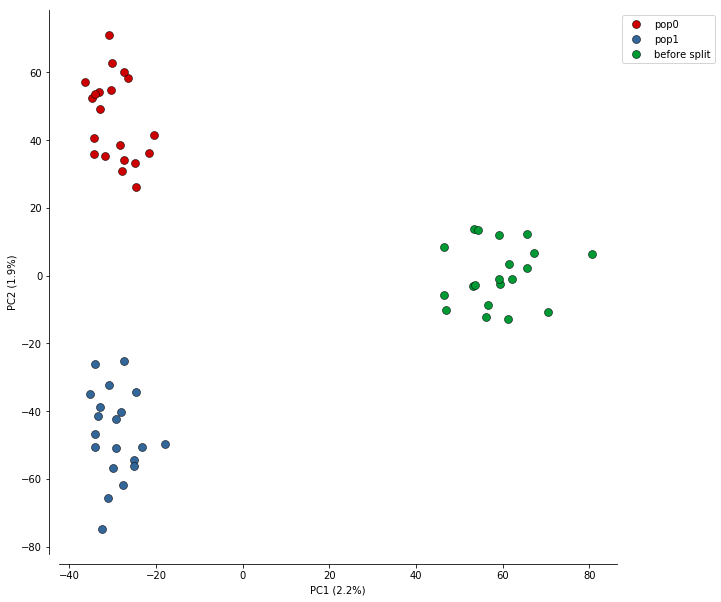

In [14]:
def plot_pca_coords(coords, model, pc1, pc2, ax):
    i = 0
    for pop in pops:
        x = coords[i:i+nbSamples, pc1]
        y = coords[i:i+nbSamples, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=pop, color=pops_colors[pop], markersize=8, mec='k', mew=.5)
        i += nbSamples
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    
fig, ax = plt.subplots(figsize=(10, 10))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

PC1 separates samples according to their age (before / after the split).<br>
PC2 separates samples from pop0 and pop1. On PC2, ancient samples are between pop0 and pop1.

Text(0.5,1.02,'PC maps')

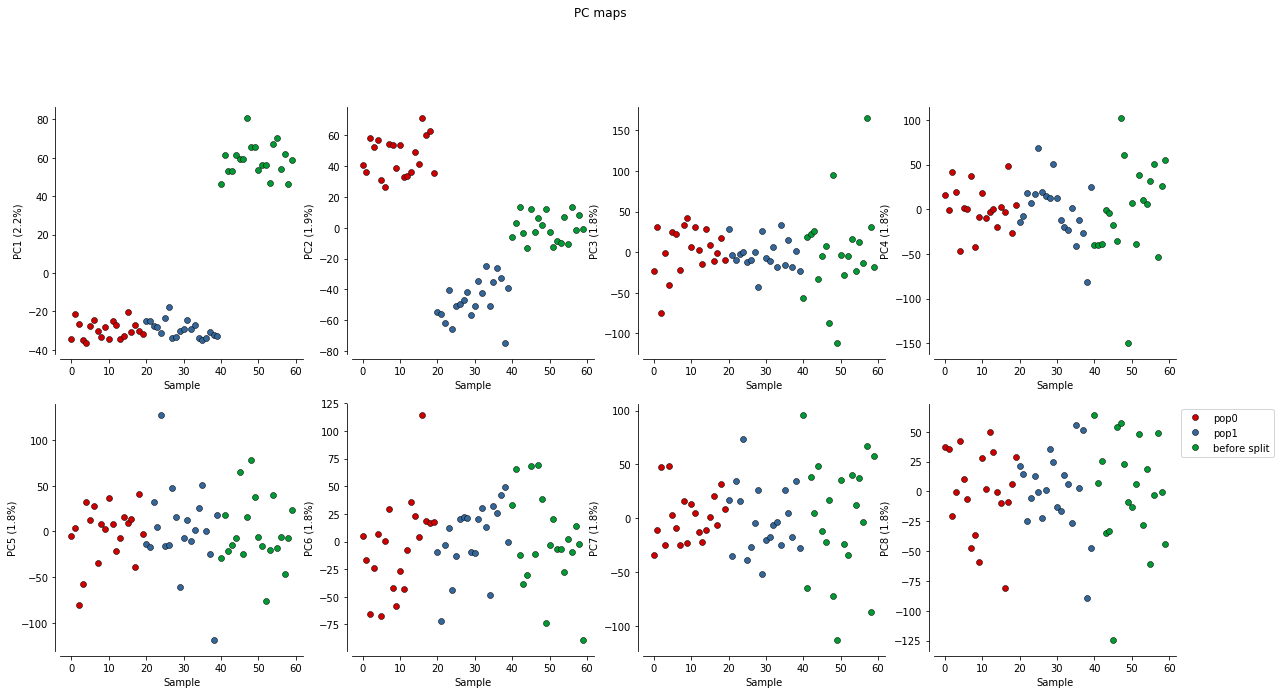

In [15]:
def plot_PC_maps(coords, model, pc, ax):
    """
    Plots each PC element against the sample number.
    """
    sns.despine(ax=ax, offset=5)
    i = 0
    for pop in pops:
        y = coords[i:i+nbSamples, pc]
        x = np.arange(i, i+nbSamples)
        ax.plot(x, y, marker='o', linestyle=' ', label=pop, color=pops_colors[pop], markersize=6, mec='k', mew=.5)
        i += nbSamples
    ax.set_ylabel('PC%s (%.1f%%)' % (pc+1, model.explained_variance_ratio_[pc]*100))
    ax.set_xlabel('Sample')

    
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,4,1)
plot_PC_maps(coords, model, 0, ax)
ax = fig.add_subplot(2,4,2)
plot_PC_maps(coords, model, 1, ax)
ax = fig.add_subplot(2,4,3)
plot_PC_maps(coords, model, 2, ax)
ax = fig.add_subplot(2,4,4)
plot_PC_maps(coords, model, 3, ax)
ax = fig.add_subplot(2,4,5)
plot_PC_maps(coords, model, 4, ax)
ax = fig.add_subplot(2,4,6)
plot_PC_maps(coords, model, 5, ax)
ax = fig.add_subplot(2,4,7)
plot_PC_maps(coords, model, 6, ax)
ax = fig.add_subplot(2,4,8)
plot_PC_maps(coords, model, 7, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
fig.suptitle('PC maps', y=1.02)

In [16]:
sample_pops = ['pop0'] * nbM + ['pop1'] * nbM + ['before split'] * nbA
sample_times = [0] * 2*nbM + [200] * nbA

# with open("genotype_diverging_pops.txt", "w") as f:
#     for ind in np.arange(gn.shape[1]):
#         f.write("%s\t%s\t" % (sample_pops[ind], sample_times[ind]))
#         for var in np.arange(gn.shape[0]):
#             if var != gn.shape[0]-1:
#                 f.write("%s\t" % gn[var, ind])
#             else:
#                 f.write("%s\n" % gn[var, ind])

### Modern samples + ancient samples taken before and after split

**Scenario 1:**

150 generations ago, a population split into 2 populations.<br>
Modern samples are taken from these 2 populations. <br>
Ancient samples are taken 500 generations ago and 300 generations ago in the ancestral population.<br>
Ancient samples are taken 100 generations ago in pop0 and pop1.

In [17]:
Ne = 15000
nbPops = 2
nbM = 20
nbA = 20

population_configurations=[
    msprime.PopulationConfiguration(initial_size=Ne),
    msprime.PopulationConfiguration(initial_size=Ne)]
demographic_events=[
    msprime.MassMigration(150, source=1, dest=0)] # pop0 migrated to pop1
samples = [msprime.Sample(0,0) for i in np.arange(2*nbM)] + [msprime.Sample(1,0) for i in np.arange(2*nbM)]
samples += [msprime.Sample(0,500) for i in np.arange(2*nbA)] + [msprime.Sample(0,300) for i in np.arange(2*nbA)]
samples += [msprime.Sample(0,100) for i in np.arange(2*nbA)] + [msprime.Sample(1,100) for i in np.arange(2*nbA)]

In [18]:
def run_sim3(num_replicates, nbM, nbA, nbPops, population_configurations, demographic_events):
    """
    Runs num_replicates simulations, each one generating a very small number of SNPs. All these mutations are
    pooled in order get thousands of independent SNPs.
    """
    s = 0
    replicates = msprime.simulate(length= 400,
                                  samples = samples,
                                  mutation_rate=1e-8, recombination_rate=1e-8,
                                  num_replicates=num_replicates,
                                  population_configurations = population_configurations,
                                  demographic_events=demographic_events,
                                 random_seed = 42)
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (nbPops*nbM + nbPops*nbA + 2*nbA,2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    return(haplotypes)

In [19]:
g = allel.model.GenotypeArray(run_sim3(25000, nbM, nbA, nbPops, population_configurations,
                                                         demographic_events))
g

<GenotypeArray shape=(38940, 120, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/1 1/1 1/0 1/0 1/1 ... 1/0 0/1 0/1 1/0 1/0
1/0 0/0 0/1 0/0 0/0 ... 0/0 0/0 1/0 0/1 0/1
...
0/1 0/0 0/1 0/0 1/1 ... 1/0 1/1 1/0 1/1 1/1
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [20]:
gn = g.to_n_alt()[:]

# with open("genotype_split.txt", "w") as f:
#     for ind in np.arange(gn.shape[1]):
#         for var in np.arange(gn.shape[0]):
#             if var != gn.shape[0]-1:
#                 f.write("%s\t" % gn[var, ind])
#             else:
#                 f.write("%s\n" % gn[var, ind])

# PCA
coords, model = allel.stats.pca(gn)
coords.shape

pops_colors = {
    'pop0': '#ff0000',
    'pop1': '#0000ff',
    'before split, 500': '#8000ff',
    'before split, 300':'#bf80ff',
    'pop0, 100': '#ff8000',
    'pop1, 100': '#00bfff'
}

pops = []
for d in np.arange(nbPops):
    pops.append("pop" + str(d))
pops.append('before split, 500')
pops.append('before split, 300')
pops.append('pop0, 100')
pops.append('pop1, 100')

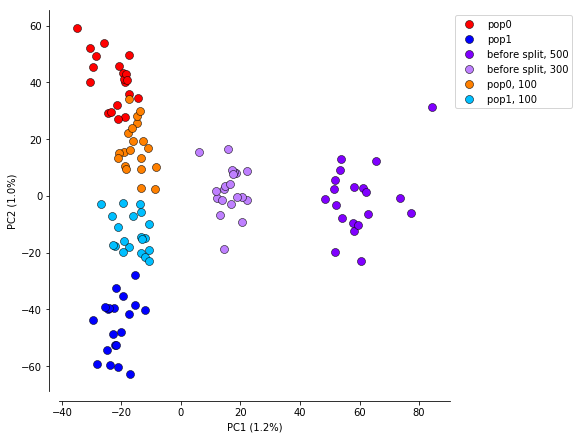

In [21]:
fig, ax = plt.subplots(figsize=(7,7))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

Text(0.5,1.02,'PC maps')

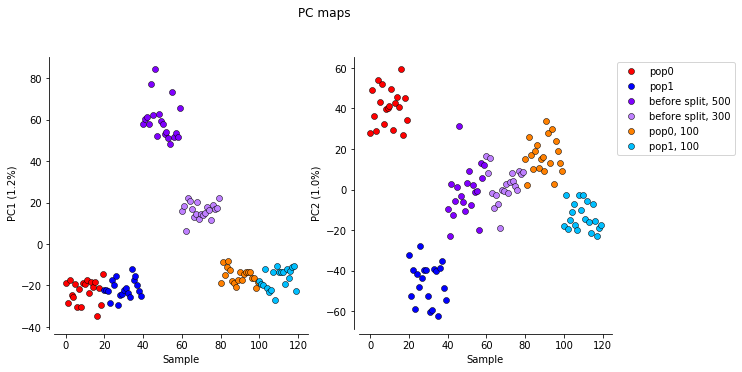

In [22]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
plot_PC_maps(coords, model, 0, ax)
ax = fig.add_subplot(1,2,2)
plot_PC_maps(coords, model, 1, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
fig.suptitle('PC maps', y=1.02)

PC1 separates samples according to their age.<br>
PC2 separates them according to their population. Samples taken before the split are in the middle.

### Modern samples + ancient samples taken before and after split

**Scenario 2:**


150 generations ago, a population split into 2 populations.<br>
Modern samples are taken from these 2 populations. <br>
Ancient samples are taken 200 generations ago in the ancestral population.<br>
Ancient samples are taken 100 generations ago in pop0 and pop1.

In [23]:
Ne = 15000
nbPops = 2
nbM = 20
nbA = 20

population_configurations=[
    msprime.PopulationConfiguration(initial_size=Ne),
    msprime.PopulationConfiguration(initial_size=Ne)]
demographic_events=[
    msprime.MassMigration(150, source=1, dest=0)] # pop0 migrated to pop1
samples = [msprime.Sample(0,0) for i in np.arange(2*nbM)] + [msprime.Sample(1,0) for i in np.arange(2*nbM)]
samples += [msprime.Sample(0,200) for i in np.arange(2*nbA)]
samples += [msprime.Sample(0,100) for i in np.arange(2*nbA)] + [msprime.Sample(1,100) for i in np.arange(2*nbA)]

In [24]:
def run_sim4(num_replicates, nbM, nbA, nbPops, population_configurations, demographic_events):
    """
    Runs num_replicates simulations, each one generating a very small number of SNPs. All these mutations are
    pooled in order get thousands of independent SNPs.
    """
    s = 0
    replicates = msprime.simulate(length= 400,
                                  samples = samples,
                                  mutation_rate=1e-8, recombination_rate=1e-8,
                                  num_replicates=num_replicates,
                                  population_configurations = population_configurations,
                                  demographic_events=demographic_events,
                                 random_seed = 42)
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (nbPops*nbM + nbPops*nbA + nbA,2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    return(haplotypes)

In [25]:
g = allel.model.GenotypeArray(run_sim4(15000, nbM, nbA, nbPops, population_configurations,
                                                         demographic_events))
g

<GenotypeArray shape=(21972, 100, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 1/1 0/1 0/0 0/1 ... 0/0 0/0 1/0 0/0 0/0
...
0/1 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/1 1/0 0/1 0/1 1/0 ... 1/1 1/1 0/0 1/1 1/1
0/1 1/0 0/1 0/1 1/0 ... 1/1 1/1 0/0 1/1 1/1

In [26]:
gn = g.to_n_alt()[:]

# PCA
coords, model = allel.stats.pca(gn)
coords.shape

pops_colors = {
    'pop0': '#ff0000',
    'pop1': '#0000ff',
    'before split, 200':'#bf80ff',
    'pop0, 100': '#ff8000',
    'pop1, 100': '#00bfff'
}

pops = []
for d in np.arange(nbPops):
    pops.append("pop" + str(d))
pops.append('before split, 200')
pops.append('pop0, 100')
pops.append('pop1, 100')

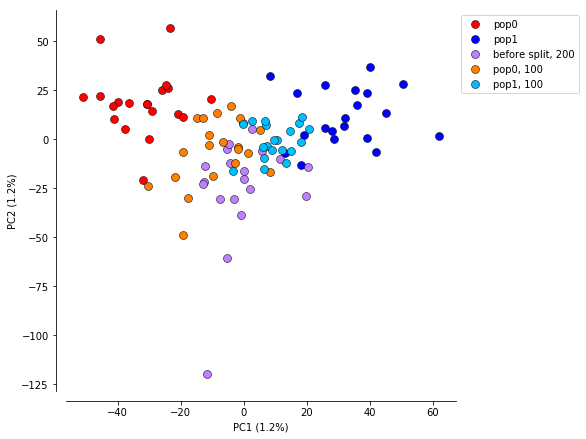

In [27]:
fig, ax = plt.subplots(figsize=(7,7))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

Text(0.5,1.02,'PC maps')

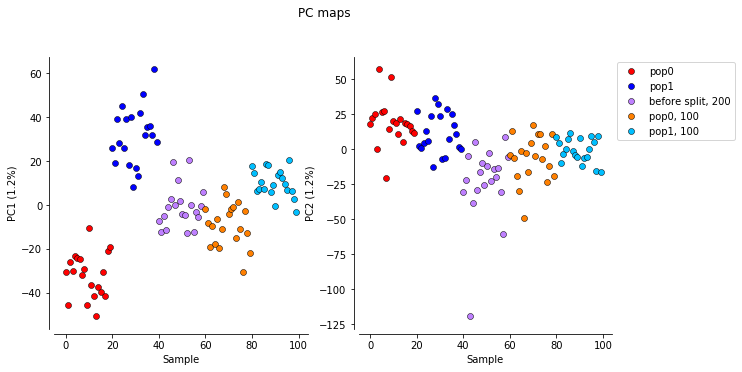

In [28]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
plot_PC_maps(coords, model, 0, ax)
ax = fig.add_subplot(1,2,2)
plot_PC_maps(coords, model, 1, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
fig.suptitle('PC maps', y=1.02)

PC1: population<br>
PC2: time

In scenario 2, there is more time between pop0 and pop1 (300 years), than between pop0/pop1 and ancestral population -> seperates according to population.

**PC1 explains the largest difference in time between samples.**

# Compare population split vs. one population for the same temporal sampling

- split 600 generations ago
- sampling between 1000 and 600 generations in ancestral population, evenly spaced (every 50 generations)
- sampling between 0 and 300 generations in modern populations, evenly spaced (every 50 generations)

In [55]:
Ne = 15000
nbSamples = 5
ages_before = [650, 700, 750, 800, 850, 900, 950]
ages_after = [0, 50, 100, 150, 200, 250, 300]
split_time = 600
# ages_before = [6500, 7000, 7500, 8000, 8500, 9000, 9500]
# ages_after = [0, 500, 1000, 1500, 2000, 2500, 3000]
# split_time = 4500

# one population
samples = []
ages = ages_after + ages_before
for a in ages:
    samples += [msprime.Sample(0,a) for i in np.arange(2*nbSamples)]
    
def run_simu_one_pop(num_replicates, nbSamples, samples, ages, Ne):
    s = 0
    replicates = msprime.simulate(Ne=Ne, length= 1e2, samples = samples,
                                  mutation_rate=1e-8, recombination_rate=1e-8,
                                  num_replicates=num_replicates)
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (nbSamples*len(ages),2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    return(haplotypes)

g_onePop = allel.model.GenotypeArray(run_simu_one_pop(30000, nbSamples, samples, ages, Ne))

# population split
population_configurations=[
    msprime.PopulationConfiguration(initial_size=Ne),
    msprime.PopulationConfiguration(initial_size=Ne)]
demographic_events=[
    msprime.MassMigration(split_time, source=1, dest=0, proportion=1)] 
samples_split = []
for a in ages_after:
    samples_split += [msprime.Sample(0,a) for i in np.arange(2*nbSamples)]
for a in ages_after:
    samples_split += [msprime.Sample(1,a) for i in np.arange(2*nbSamples)]
for a in ages_before:
    samples_split += [msprime.Sample(0,a) for i in np.arange(2*nbSamples)]

def run_simu_split(num_replicates, nbSamples, samples_split, population_configurations, demographic_events, ages_after, ages_before):
    s = 0
    replicates = msprime.simulate(length= 150,
                                  mutation_rate=1e-8, recombination_rate=1e-8,
                                  num_replicates=num_replicates,
                                  population_configurations = population_configurations,
                                  demographic_events=demographic_events,
                                  samples = samples_split)
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (2*len(ages_after)*nbSamples + len(ages_before)*nbSamples,2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    return(haplotypes)

g_split = allel.model.GenotypeArray(run_simu_split(15000, nbSamples, samples_split, population_configurations, demographic_events,
                                                  ages_after, ages_before))

In [48]:
g_onePop

<GenotypeArray shape=(14666, 70, 2) dtype=int8>
1/0 0/1 1/0 0/0 0/0 ... 0/0 0/0 1/1 1/1 1/1
1/0 0/0 1/0 0/0 0/0 ... 0/0 0/0 0/0 1/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [56]:
g_split

<GenotypeArray shape=(9062, 105, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
1/1 1/1 1/1 0/1 1/0 ... 0/1 1/1 1/1 1/1 1/1
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
1/1 0/1 0/1 1/0 1/0 ... 0/1 0/1 1/0 0/1 1/1
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [57]:
gn_split = g_split.to_n_alt()[:]
gn_onePop = g_onePop.to_n_alt()[:]

# ages_onePop = []
# for a in ages:
#     ages_onePop += [a for i in np.arange(nbSamples)]
# with open("genotype_onePop.txt", "w") as f:
#     i = 0
#     for ind in np.arange(gn_onePop.shape[1]):
#         f.write("%s\t" % ages_onePop[i])
#         for var in np.arange(gn_onePop.shape[0]):
#             if var != gn_onePop.shape[0]-1:
#                 f.write("%s\t" % gn_onePop[var, ind])
#             else:
#                 f.write("%s\n" % gn_onePop[var, ind])
#         i += 1

ages_split = []
for a in ages_after + ages_after + ages_before:
    ages_split += [a for i in np.arange(nbSamples)]
# with open("genotype_split.txt", "w") as f:
#     i = 0
#     for ind in np.arange(gn_split.shape[1]):
#         f.write("%s\t" % ages_split[i])
#         for var in np.arange(gn_split.shape[0]):
#             if var != gn_split.shape[0]-1:
#                 f.write("%s\t" % gn_split[var, ind])
#             else:
#                 f.write("%s\n" % gn_split[var, ind])
#         i += 1

coords_onePop, model_onePop = allel.stats.pca(gn_onePop, scaler=None)
coords_split, model_split = allel.stats.pca(gn_split, scaler=None)

In [33]:
palette_onePop = sns.color_palette("YlOrRd", len(ages))
palette_split = sns.color_palette("YlGnBu", len(ages) + len(ages_after))

colors_onePop = {}
onePop = []
i = 0
for a in ages:
    name = "one pop, t=" + str(a)
    onePop.append(name)
    colors_onePop[name] = palette_onePop[i]
    i += 1

colors_split = {}
split = []
i = 0
for a in ages_after:
    name = "pop0, t=" + str(a)
    split.append(name)
    colors_split[name] = palette_split[i]
    i += 1
for a in ages_after:
    name = "pop1, t=" + str(a)
    split.append(name)
    colors_split[name] = palette_split[i]
    i += 1
for a in ages_before:
    name = "ancestral pop, t=" + str(a)
    split.append(name)
    colors_split[name] = palette_split[i]
    i += 1

Text(0.5,1,'Population split')

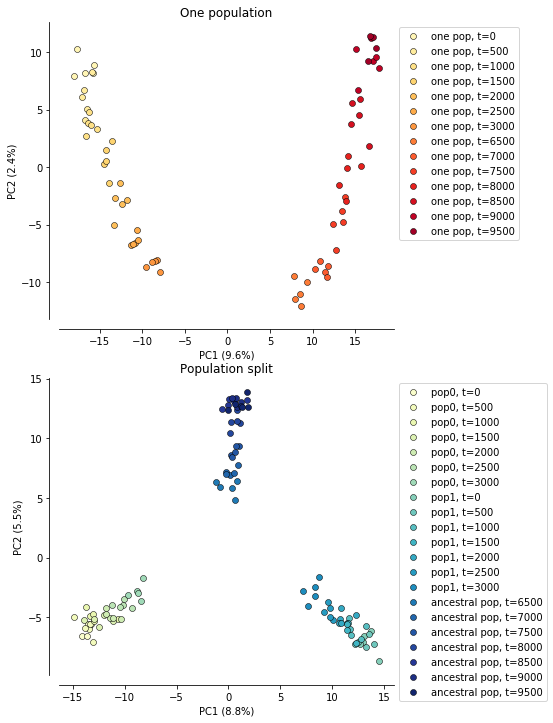

In [34]:
def plot_pca_coords(coords, model, pc1, pc2, ax, nbSamples, l, colors):
    sns.despine(ax=ax, offset=10)
    i = 0
    for a in l:
        x = coords[i:i+nbSamples, pc1]
        y = coords[i:i+nbSamples, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=a,
                color=colors[a], markersize=6, mec='k', mew=.5)
        i += nbSamples
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))    

    
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(2,1,1)
plot_pca_coords(coords_onePop, model_onePop, 0, 1, ax, nbSamples, onePop, colors_onePop)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_title("One population")
ax = fig.add_subplot(2,1,2)
plot_pca_coords(coords_split, model_split, 0, 1, ax, nbSamples, split, colors_split)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_title("Population split")

Text(0.5,1,'Population split')

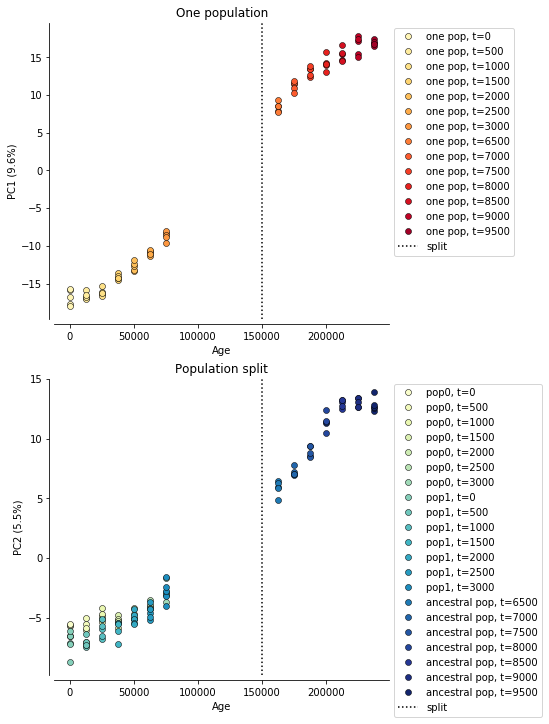

In [35]:
def plot_PC_maps(coords, model, pc, ax, nbSamples, l, colors):
    sns.despine(ax=ax, offset=5)
    i = 0
    for a in l:
        y = coords[i:i+nbSamples, pc]
        x = np.ones(len(y))
        words = a.split('=')
        ax.plot(x*int(words[1])*25, y, marker='o', linestyle=' ', label=a, color=colors[a], markersize=6, mec='k', mew=.5)
        i += nbSamples
    ax.set_ylabel('PC%s (%.1f%%)' % (pc+1, model.explained_variance_ratio_[pc]*100))
    ax.set_xlabel('Age')
    ax.axvline(split_time*25, linestyle=':', color="black", label="split")
    
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(2,1,1)
plot_PC_maps(coords_onePop, model_onePop, 0, ax, nbSamples, onePop, colors_onePop)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_title("One population")
ax = fig.add_subplot(2,1,2)
plot_PC_maps(coords_split, model_split, 1, ax, nbSamples, split, colors_split)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_title("Population split")

## Fst between populations

In [36]:
import csv
import pandas

pops_names = ['0', '1', 'ancestral']

k = 0
with open('split_600.csv', 'w') as f:
    fieldnames = ['index', 'population']
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for i in np.arange(len(pops_names)):
        for j in np.arange(nbSamples*len(ages_before)): # len(ages_after) == len(ages_before)
            writer.writerow({'index': str(k), 'population': pops_names[i]})
            k += 1

    
df_samples = pandas.read_csv('split_600.csv', sep=',', index_col='index')

subpops = {
    '0': df_samples[df_samples.population == '0'].index.tolist(),
    '1': df_samples[df_samples.population == '1'].index.tolist(),
    'ancestral': df_samples[df_samples.population == 'ancestral'].index.tolist()
}

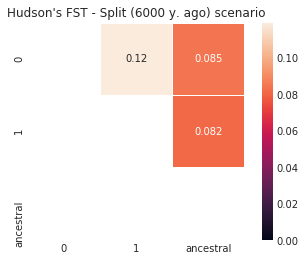

In [37]:
acs = g_split.count_alleles_subpops(subpops)

fst_matrix = np.zeros((len(pops_names), len(pops_names)))

for i in np.arange(len(pops_names)):
    for j in np.arange(len(pops_names)):
        if i != j:
            pop1 = pops_names[i]
            pop2 = pops_names[j]
            acu = allel.AlleleCountsArray(acs[pop1][:] + acs[pop2][:])
            flt = acu.is_segregating()
            ac1 = allel.AlleleCountsArray(acs[pop1].compress(flt, axis=0)[:, :2])
            ac2 = allel.AlleleCountsArray(acs[pop2].compress(flt, axis=0)[:, :2])
            # compute FST
            num, den = allel.stats.hudson_fst(ac1, ac2)
            fst = np.sum(num) / np.sum(den)
            fst_matrix[i, j] = fst
        else:
            fst_matrix[i, j] = 0

mask = np.zeros_like(fst_matrix)
mask[np.tril_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(fst_matrix, xticklabels=pops_names, yticklabels=pops_names, annot=True, mask=mask, square=True,
                    linewidths=.5)
ax.set_title("Hudson's FST - Split (" + str(split_time) + " y. ago) scenario")
plt.show()

In [38]:
new_gn = []
for v in np.arange(gn_split.shape[0]):
    moy = np.mean(gn_split[v,:])
    var = np.var(gn_split[v,:])
#     new_gn.append((gn[v,:] - moy)/np.sqrt(var))
    new_gn.append(gn_split[v,:] - moy)
new_gn = np.asarray(new_gn)

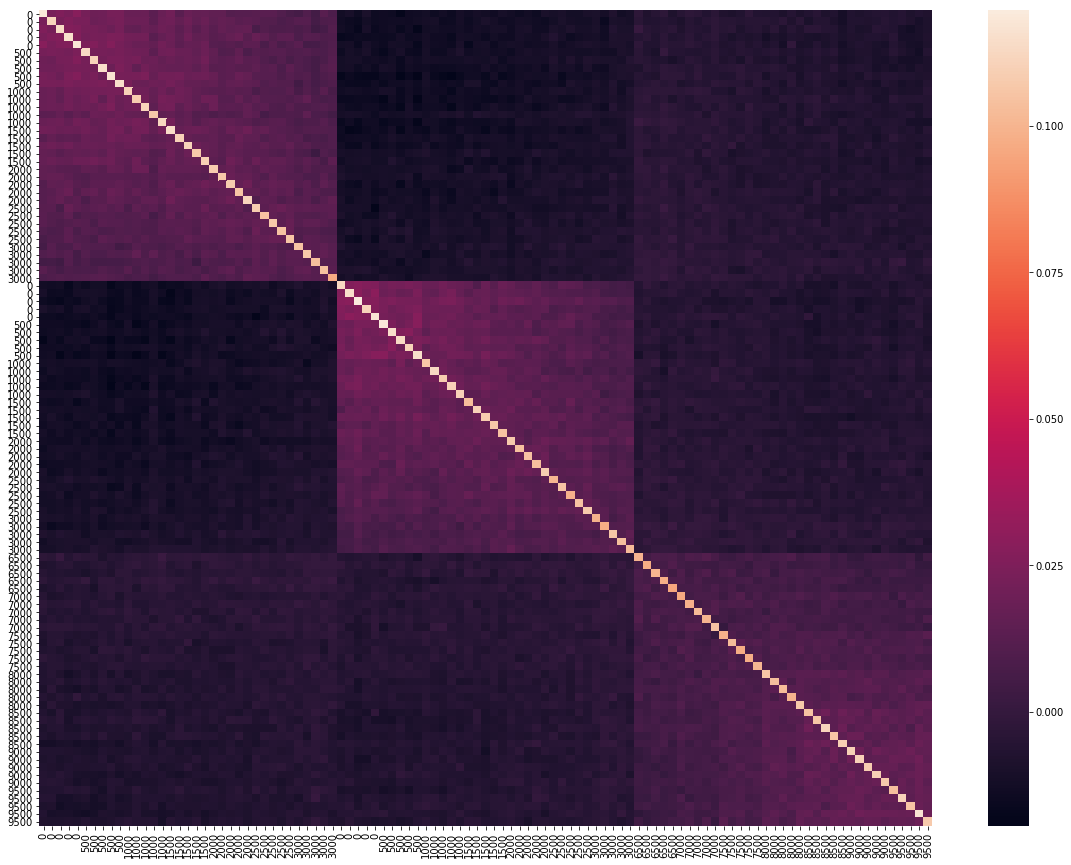

In [39]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(np.cov(new_gn, rowvar=False), xticklabels=ages_split, yticklabels=ages_split)